In [176]:
#####Dynamic Poisson Regression model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [177]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z

In [178]:
####データの生成####
##データの設定
d = 2000   #観測期間
pt = np.arange(d)   #id
k = 3   #説明変数数

In [179]:
##動的回帰モデルのデータを生成
rp = 0
while True:
    rp = rp + 1
    
    ##説明変数を生成
    #データの設定
    candidate = 5
    x = np.zeros((d, k))
    x[0, ] = np.array([0.7, -0.5, -0.5])
    v = np.random.uniform(0.015, 0.03, k)   #システムモデルの分散
    prob = np.hstack((np.arange(0.4, 0.7, (0.7-0.4)/(d-1))[::-1], 
                      np.arange(0.4, 0.7, (0.7-0.4)/(d-1)),
                      np.arange(0.4, 0.7, (0.7-0.4)/(d-1)))).reshape(d-1, k, order="F")

    #システム分散から動的変数を生成
    for i in range(1, d):
        for j in range(k):
            diff = np.random.normal(0, v[j], candidate)
            sortlist = np.sort(diff)
            z = np.random.binomial(1, prob[i-1, j], 1)
            x[i, j] = x[i-1, j] + z*sortlist[3] + (1-z)*sortlist[1]

    #価格の割引率を生成
    z = np.random.normal(0.9, 0.15, d)
    x[:, 0] = x[:, 0] * (z >= 1)*1 + (z < 1)*z

    #二値変数を生成
    u = x[:, 1:] + np.random.normal(0, 1.0, d*2).reshape(d, 2)
    x[:, 1:] = np.array(u > 0, dtype="int")

    ##動的パラメータを生成
    #初期値の設定
    target1 = np.array([3, 1, 3, 3]); target2 = np.array([1, 3, 1, 1])
    beta = np.zeros((d, k+1))
    beta[0, ] = np.array([2.0, -1.2, 0.5, 0.6])
    tau = 0.01
    
    #時間ごとにパラメータを生成
    prob = np.hstack((np.arange(0.2, 0.8, (0.8-0.2)/(d-1))[::-1], 
                      np.arange(0.4, 0.6, (0.6-0.4)/(d-1))[::-1],
                      np.arange(0.4, 0.7, (0.7-0.4)/(d-1)),
                      np.arange(0.4, 0.6, (0.6-0.4)/(d-1)))).reshape(d-1, k+1, order="F")

    for i in range(1, d):
        diff = np.random.normal(0, tau, (k+1)*candidate)
        sortlist = np.sort(diff.reshape(k+1, candidate), axis=1)
        z = np.random.binomial(1, prob[i-1])
        for j in range(k+1):
            beta[i, j] = beta[i-1, j] + z[j]*sortlist[j, target1[j]] + (1-z[j])*sortlist[j, target2[j]]
    betat = beta.copy()
        
    ##応答変数を生成
    Lambda = np.exp(np.sum(np.hstack((beta[:, 0][:, np.newaxis], x*beta[:, 1:])), axis=1))   
    y = np.random.poisson(Lambda, d)

    #break条件
    print(np.round([np.mean(y), np.max(y)], 2))
    if (np.mean(y) > 1.5) & (np.max(y) < 30.0) & (np.max(y) > 10.0):
        break

[ 5.6 33. ]
[ 8.71 39.  ]
[ 4.54 31.  ]
[ 6.43 34.  ]
[ 7.99 30.  ]
[ 7.47 42.  ]
[ 6.38 42.  ]
[ 3.53 18.  ]


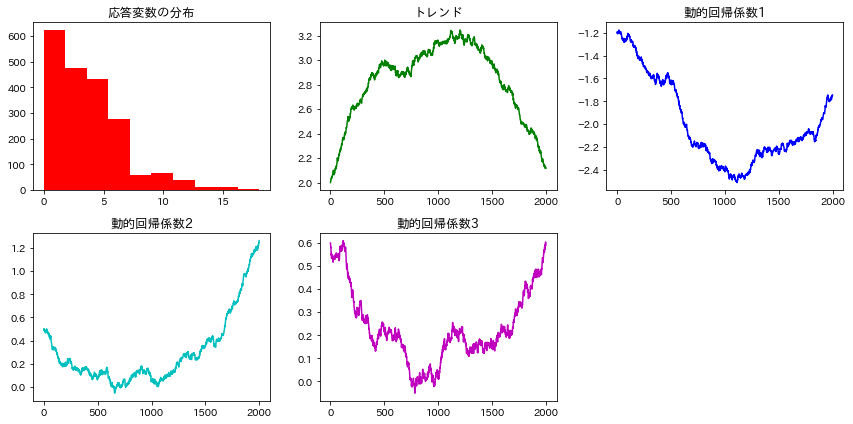

In [180]:
#応答変数とトレンドを可視化
dt = [y, beta[:, 0], beta[:, 1], beta[:, 2], beta[:, 3]]
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["応答変数の分布", "トレンド", "動的回帰係数1", "動的回帰係数2", "動的回帰係数3"]
fig = plt.figure(figsize=(12.0, 6.0))

ax = fig.add_subplot(2, 3, 1)
plt.hist(y, bins=10, color=colorlist[0])
plt.title(legend[0], fontsize=12.5)
for j in range(1, len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.plot(dt[j], color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [115]:
####粒子フィルタでパラメータを推定####
##動的ポアソン回帰モデルを推定するための関数
#対数尤度関数を定義
def fr(beta, x, y, y_factorial):
    Lambda = np.exp(np.dot(x, beta))
    LL = np.sum(y*np.log(Lambda) - Lambda - y_factorial)
    return -LL

#勾配ベクトルを定義
def gradient(beta, x, y, y_factorial):
    Lambda = np.exp(np.dot(x, beta))
    LLd = np.sum(y[:, np.newaxis]*x - x*Lambda[:, np.newaxis], axis=0)
    return -LLd

#粒子フィルタの静的パラメータを推定するための関数
def particle_fr(tau, beta, x, y, y_factorial, k, d, s_vec):
    #パラメータを設定
    LL = np.repeat(0.0, d)
    BETA = np.zeros((s, k+1, d))
    Cov = np.diag(np.abs(tau))

    ##1期目の粒子をサンプリング
    #システムモデルのパラメータをサンプリング
    betan = beta + np.random.multivariate_normal(np.repeat(0, k+1), Cov, s)

    #観測モデルの尤度を評価
    Lambda = np.exp(np.sum(np.hstack((betan[:, 0][:, np.newaxis], x[0, ] * betan[:, 1:])), axis=1))
    Li = np.exp(y[0]*np.log(Lambda) - Lambda - y_factorial[0])   #粒子ごとの尤度
    LL[0] = np.sum(Li)   #尤度の和

    #尤度の負担率に応じてパラメータをリサンプリング
    w = Li / LL[0]
    index = np.random.multinomial(s, w, 1).reshape(-1)
    resample = np.repeat(s_vec, index)
    BETA[:, :, 0] = betan[resample, ]

    ##2期目以降の粒子をサンプリング
    for i in range(1, d):
        #システムモデルのパラメータをサンプリング
        betan = BETA[:, :, i-1] + np.random.multivariate_normal(np.repeat(0, k+1), Cov, s)

        #観測モデルの尤度を評価
        Lambda = np.exp(np.sum(np.hstack((betan[:, 0][:, np.newaxis], x[i, ] * betan[:, 1:])), axis=1))
        Li = np.exp(y[i]*np.log(Lambda) - Lambda - y_factorial[i])   #粒子ごとの尤度
        LL[i] = np.sum(Li)   #尤度の和

        #尤度の負担率に応じてパラメータをリサンプリング
        w = Li / LL[i]
        index = np.random.multinomial(s, w, 1).reshape(-1)
        resample = np.repeat(s_vec, index)
        BETA[:, :, i] = betan[resample, ]

    ##対数尤度の和
    LLs = np.sum(np.log(LL)) - d*np.log(s)
    return -LLs

In [69]:
##粒子フィルタで静的パラメータを推定
#アルゴリズムの設定
s = 1000   #粒子数
s_vec =np.arange(s)
LL = np.repeat(0.0, d)
BETA = np.zeros((s, k+1, d))
y_factorial = scipy.special.gammaln(y+1)

#準ニュートン法で初期値を設定
index = np.arange(200)
beta = np.repeat(0.0, k+1)
new_x = np.hstack((np.repeat(1, index.shape[0])[:, np.newaxis], x[index, ]))
res = optimize.minimize(fr, beta, jac=gradient, method="BFGS", args=(new_x, y[index], y_factorial[index]),
                        options={"gtol": 0.1, "disp":True})
beta = res.x

#静的パラメータを推定
tau = np.repeat(0.001, k+1)
res = optimize.minimize(particle_fr, tau, method="Nelder-Mead", args=(beta, x, y, y_factorial, k, d, s_vec), options={"disp":True})
tau = np.diag(np.power(res.x, 2))

Optimization terminated successfully.
         Current function value: 412.810673
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15


In [181]:
##動的パラメータをリサンプリング
#アルゴリズムを設定
s = 10000   #粒子数
s_vec =np.arange(s)
LL = np.repeat(0.0, d)
BETA = np.zeros((s, k+1, d))
Cov = np.diag(np.power(np.repeat(0.05, k+1), 2))
y_factorial = scipy.special.gammaln(y+1)

##1期目の粒子をサンプリング
#システムモデルのパラメータをサンプリング
betan = betat[0, ] + np.random.multivariate_normal(np.repeat(0, k+1), Cov, s)

#観測モデルの尤度を評価
Lambda = np.exp(np.sum(np.hstack((betan[:, 0][:, np.newaxis], x[0, ] * betan[:, 1:])), axis=1))
Li = np.exp(y[0]*np.log(Lambda) - Lambda - y_factorial[0])   #粒子ごとの尤度
LL[0] = np.sum(Li)   #尤度の和

#尤度の負担率に応じてパラメータをリサンプリング
w = Li / LL[0]
index = np.random.multinomial(s, w, 1).reshape(-1)
resample = np.repeat(s_vec, index)
BETA[:, :, 0] = betan[resample, ]

##2期目以降の粒子をサンプリング
for i in range(1, d):
    #システムモデルのパラメータをサンプリング
    betan = BETA[:, :, i-1] + np.random.multivariate_normal(np.repeat(0, k+1), Cov, s)

    #観測モデルの尤度を評価
    Lambda = np.exp(np.sum(np.hstack((betan[:, 0][:, np.newaxis], x[i, ] * betan[:, 1:])), axis=1))
    Li = np.exp(y[i]*np.log(Lambda) - Lambda - y_factorial[i])   #粒子ごとの尤度
    LL[i] = np.sum(Li)   #尤度の和

    #尤度の負担率に応じてパラメータをリサンプリング
    w = Li / LL[i]
    index = np.random.multinomial(s, w, 1).reshape(-1)
    resample = np.repeat(s_vec, index)
    BETA[:, :, i] = betan[resample, ]

##対数尤度の和
LLs = np.sum(np.log(LL)) - d*np.log(s)

In [182]:
##推定結果の要約と可視化
#事後平均と事後分位点
beta = np.mean(BETA, axis=0).T
beta_lower = np.percentile(BETA, 5.0, axis=0).T
beta_upper = np.percentile(BETA, 95.0, axis=0).T

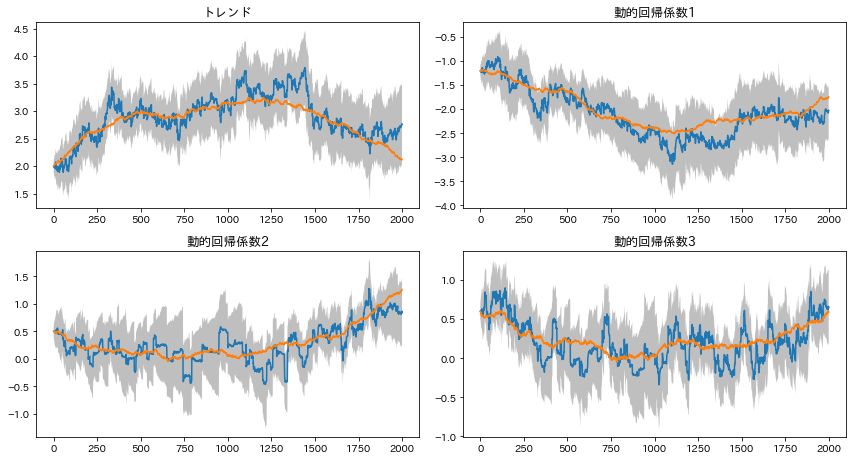

In [183]:
#動的パラメータを可視化
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["トレンド", "動的回帰係数1", "動的回帰係数2", "動的回帰係数3"]
fig = plt.figure(figsize=(12.0, 6.5))
for j in range(k+1):
    ax = fig.add_subplot(2, 2, j+1)
    ax.plot(beta[:, j])
    ax.plot(betat[:, j])
    ax.fill_between(np.arange(d), beta_upper[:, j], beta_lower[:, j], facecolor="grey", alpha=0.5)
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()